In [12]:
!pip install tensorflow opencv-python matplotlib seaborn scikit-learn mediapipe --quiet

import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import mediapipe as mp
print("All packages installed successfully!")

All packages installed successfully!


In [14]:
!pip install tensorflow opencv-python matplotlib seaborn scikit-learn mediapipe --quiet

import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import mediapipe as mp

print("All packages installed and imported successfully!")

All packages installed and imported successfully!


In [26]:
def load_hand_gesture_data():
    """
    Create sample hand gesture data for demonstration
    In real scenario, replace this with actual dataset loading
    """
    print("Creating sample hand gesture data...")

    class_names = ['fist', 'open_palm', 'thumbs_up', 'peace', 'ok_sign', 'pointing']

    images = []
    labels = []

    for class_idx, gesture_name in enumerate(class_names):
        for i in range(150):

            img = np.random.rand(128, 128, 3) * 0.2

            if gesture_name == 'fist':

                cv2.circle(img, (64, 64), 35, (1.0, 1.0, 1.0), -1)

            elif gesture_name == 'open_palm':

                points = np.array([
                    [64, 25], [50, 50], [35, 50], [45, 70],
                    [40, 95], [64, 80], [88, 95], [83, 70],
                    [93, 50], [78, 50]
                ], np.int32)
                cv2.fillPoly(img, [points], (1.0, 1.0, 1.0))

            elif gesture_name == 'thumbs_up':

                cv2.rectangle(img, (45, 45), (83, 83), (1.0, 1.0, 1.0), -1)
                cv2.rectangle(img, (55, 25), (73, 45), (1.0, 1.0, 1.0), -1)

            elif gesture_name == 'peace':

                cv2.rectangle(img, (40, 40), (88, 88), (1.0, 1.0, 1.0), -1)
                cv2.rectangle(img, (45, 20), (55, 40), (1.0, 1.0, 1.0), -1)
                cv2.rectangle(img, (73, 20), (83, 40), (1.0, 1.0, 1.0), -1)

            elif gesture_name == 'ok_sign':

                cv2.circle(img, (64, 64), 30, (1.0, 1.0, 1.0), -1)
                cv2.circle(img, (64, 64), 12, (0.0, 0.0, 0.0), -1)

            elif gesture_name == 'pointing':

                cv2.rectangle(img, (45, 45), (83, 83), (1.0, 1.0, 1.0), -1)
                cv2.rectangle(img, (60, 20), (68, 45), (1.0, 1.0, 1.0), -1)


            noise = np.random.normal(0, 0.05, img.shape)
            img = np.clip(img + noise, 0, 1)

            images.append(img)
            labels.append(class_idx)

    return np.array(images), np.array(labels), class_names


X, y, class_names = load_hand_gesture_data()

print(f"Dataset created: {X.shape[0]} images, {len(class_names)} classes")
print(f"Class names: {class_names}")
print(f"Image shape: {X[0].shape}")

Creating sample hand gesture data...
Dataset created: 900 images, 6 classes
Class names: ['fist', 'open_palm', 'thumbs_up', 'peace', 'ok_sign', 'pointing']
Image shape: (128, 128, 3)


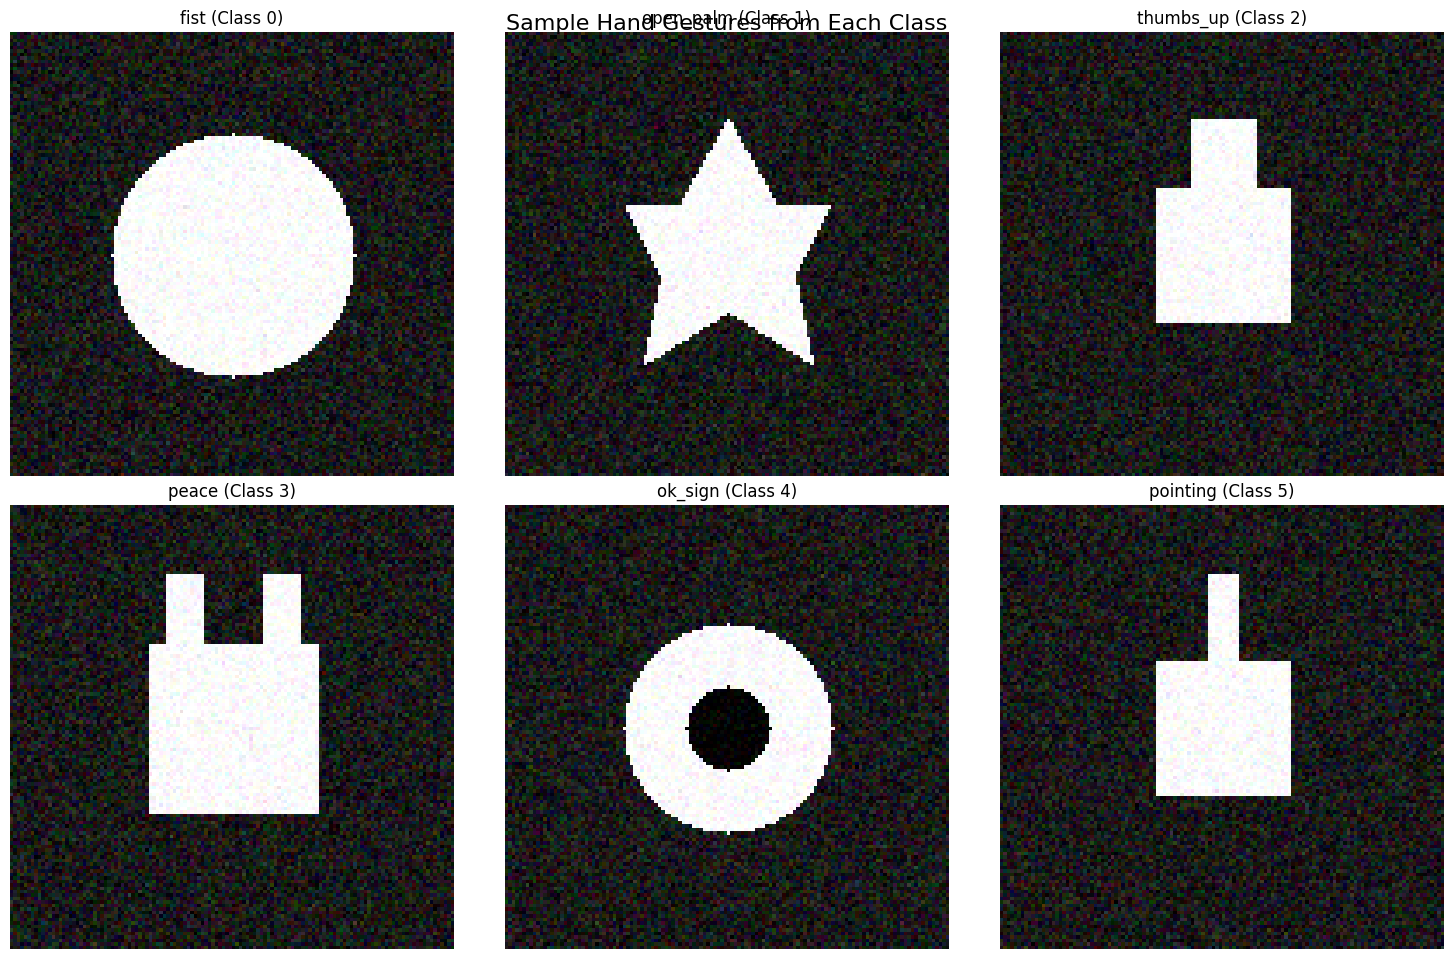

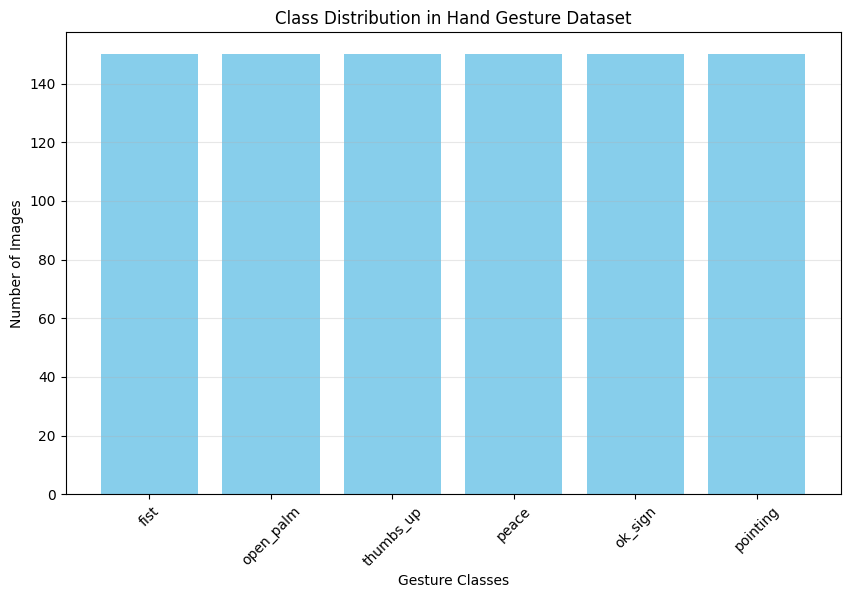

In [16]:
plt.figure(figsize=(15, 10))

for class_idx in range(len(class_names)):
    class_indices = np.where(y == class_idx)[0]
    sample_idx = class_indices[0]

    plt.subplot(2, 3, class_idx + 1)
    plt.imshow(X[sample_idx])
    plt.title(f'{class_names[class_idx]} (Class {class_idx})')
    plt.axis('off')

plt.suptitle('Sample Hand Gestures from Each Class', fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
unique, counts = np.unique(y, return_counts=True)
plt.bar([class_names[i] for i in unique], counts, color='skyblue')
plt.title('Class Distribution in Hand Gesture Dataset')
plt.xlabel('Gesture Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

In [27]:
def preprocess_data(images, labels, test_size=0.2, val_size=0.2):
    """Split data into train, validation, and test sets"""

    y_categorical = to_categorical(labels, num_classes=len(class_names))

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        images, y_categorical, test_size=test_size, random_state=42, stratify=labels
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=val_size,
        random_state=42,
        stratify=np.argmax(y_train_val, axis=1)
    )

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(X, y)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

print("Data preprocessing completed!")

Training set: 576 samples
Validation set: 144 samples
Test set: 180 samples
Data preprocessing completed!


In [18]:
def create_gesture_model(input_shape, num_classes):
    """Create CNN model for hand gesture recognition"""

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

input_shape = X_train[0].shape
num_classes = len(class_names)

model = create_gesture_model(input_shape, num_classes)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model created successfully!")
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model created successfully!


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 8,915,398 (34.01 MB)

 Trainable params: 8,912,902 (34.00 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)
]

print("Starting model training...")

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("Model training completed!")

Starting model training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.1927 - loss: 2.5059 - val_accuracy: 0.1667 - val_loss: 1.8105 - learning_rate: 0.0010
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.2533 - loss: 2.3398 - val_accuracy: 0.1667 - val_loss: 2.3842 - learning_rate: 0.0010
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.2686 - loss: 2.0667 - val_accuracy: 0.1667 - val_loss: 2.6784 - learning_rate: 0.0010
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3173 - loss: 1.8416 - val_accuracy: 0.1667 - val_loss: 2.8491 - learning_rate: 0.0010
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3395 - loss: 1.8401 - val_accuracy: 0.1667 - val_loss: 2.3243 - learning_rate: 0.0010
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3701 - loss: 1.6839
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.3697 - loss: 1.6859 - val_accuracy: 0.

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 589ms/step
Test Accuracy: 0.1667 (16.67%)

 Classification Report:
              precision    recall  f1-score   support

        fist       0.00      0.00      0.00        30
   open_palm       0.00      0.00      0.00        30
   thumbs_up       0.00      0.00      0.00        30
       peace       0.00      0.00      0.00        30
     ok_sign       0.00      0.00      0.00        30
    pointing       0.17      1.00      0.29        30

    accuracy                           0.17       180
   macro avg       0.03      0.17      0.05       180
weighted avg       0.03      0.17      0.05       180



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


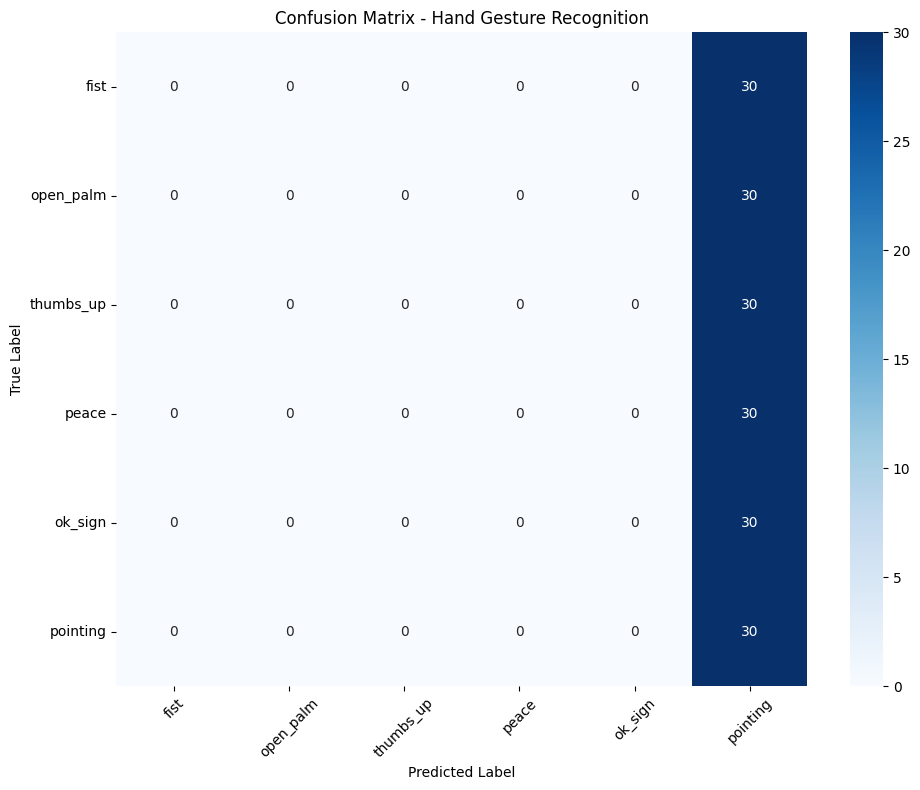

In [20]:
def evaluate_model(model, X_test, y_test, class_names):
    """Comprehensive model evaluation"""

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    test_accuracy = np.mean(y_pred_classes == y_true_classes)

    print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print("\n Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix - Hand Gesture Recognition')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return test_accuracy

test_accuracy = evaluate_model(model, X_test, y_test, class_names)

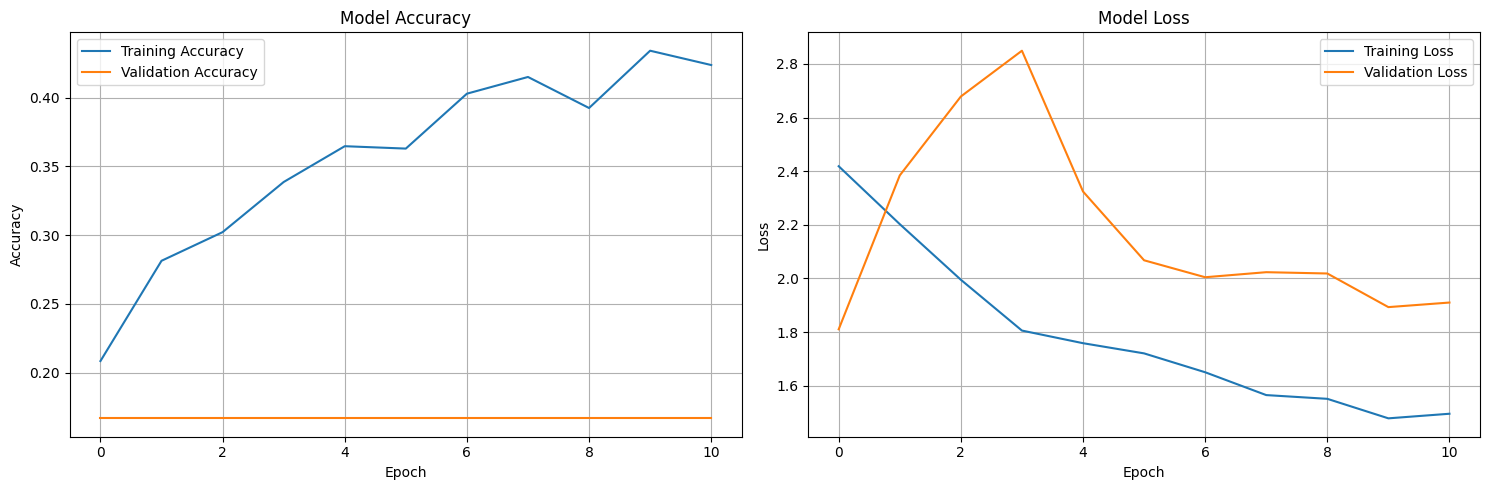

In [22]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [25]:
model.save('hand_gesture_model.keras')
print("Model saved as 'hand_gesture_model.keras'")

import json
with open('gesture_classes.json', 'w') as f:
    json.dump(class_names, f)
print("Class names saved as 'gesture_classes.json'")

print("Hand Gesture Recognition Model Completed Successfully!")

Model saved as 'hand_gesture_model.keras'
Class names saved as 'gesture_classes.json'
Hand Gesture Recognition Model Completed Successfully!
